In the following we will use the derivations from the simple FA model
to obtain a probabilistic version of CCA.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt


Let $X$ and $Y$ be two aligned data sets of dimensions $p_x \times n$ and $p_y \times n$.
We refer to the corresponding $i_{th}$ observations as $x_i$, $y_i$ -- these are column
vectors of dimensions $p_x$, and $p_y$ respectively. We consider a generative model under
which there exist latent variables $z_i \in \mathbb{R}^k$ with $i \in \{1, 2, \ldots n\}$, 
such that:

\begin{align}
p(x_i | z_i)  &= \mathcal{N} (W_x z_i + \mu_x, \Psi_x) \\
p(y_i | z_i)  &= \mathcal{N} (W_y z_i + \mu_y, \Psi_y) \\
p(z_i) &=  \mathcal{N}(0, I_{k})
\end{align}



Here $W_x \in \mathbb{R}^{p_x \times k}$, and $W_y \in \mathbb{R}^{p_y \times k}$.


The updates for this model follow from a factor model with

\begin{align}
\Lambda = \begin{bmatrix}
    W_x \\
    W_y
\end{bmatrix},
\Psi = \begin{bmatrix}
    \Psi_x & 0 \\
    0 & \Psi_y
    \end{bmatrix},\
 v_i = (x_i; y_i) \in \mathbb{R}^{p_x + p_y}
\end{align}

In particular, letting, 
\begin{align}
\beta = \Lambda^\top (\Lambda \Lambda^\top + \Psi)^{-1},
\end{align}

The latent expectation and covariance are given by the formulas

\begin{align}
\mathbb{E}[z | v_i] &= \beta v_i \\
\mathbb{E}[z z^\top | v_i] &= I_{k} - \beta \Lambda + \beta v_i v_i^\top \beta^\top,
\end{align}

Putting everything together,

\begin{align}
\Lambda^* & = \left(\sum_{i=1}^n v_i \mathbb{E}[z|v_i]^\top \right) \left(\sum_{i=1}^n \mathbb{E}[z z^\top | v_i]\right)^{-1} \\
\Psi^* & = \frac{1}{n} diag(\sum_{i=1}^n v_i v_i^\top - \Lambda^* \mathbb{E}[z|v_i] v_i^\top)
\end{align}

In [3]:
def gen_simple_dataset(p_x, p_y, k, n, sigma_x, sigma_y):
    
    X     = np.zeros((p_x, n))
    Y     = np.zeros((p_y, n))
    
    W_x   = np.random.random((p_x, k))
    
    #a = np.zeros((3, 5),int)
    #fill_diagonal(a, 4, wrap=True)
    
    W_y   = np.random.random((p_y, k))
    
    Z     = np.random.random((k, n))
    
    m_x   = np.dot(W_x, Z)
    m_y   = np.dot(W_y, Z)
    
    
    Psi_x = sigma_x * np.eye(p_x)
    Psi_y = sigma_y * np.eye(p_y)
    
    for i in range(n):
        X[:,i] = np.random.multivariate_normal(mean = m_x[:,i], cov = Psi_x)
        Y[:,i] = np.random.multivariate_normal(mean = m_y[:,i], cov = Psi_y)
        
    return X, Y, Z, W_x, W_y, Psi_x, Psi_y


def gen_simple_dataset_2(p_x, p_y, k, n, sigma_x, sigma_y):
    
    X     = np.zeros((p_x, n))
    Y     = np.zeros((p_y, n))
    
    W_x   = np.random.random((p_x, k))
    
    a     = np.zeros((p_y, p_x), int)
    np.fill_diagonal(a, 1, wrap=True)
    
    b     = np.zeros((p_y, k), int)
    np.fill_diagonal(b, 2., wrap=True)
    
    W_y   = b + np.random.random((p_y, k)) + np.dot(a, W_x)
    
    Z     = np.random.random((k, n))
    
    m_x   = np.dot(W_x, Z)
    m_y   = np.dot(W_y, Z)
    
    
    Psi_x = sigma_x * np.eye(p_x)
    Psi_y = sigma_y * np.eye(p_y)
    
    for i in range(n):
        X[:,i] = np.random.multivariate_normal(mean = m_x[:,i], cov = Psi_x)
        Y[:,i] = np.random.multivariate_normal(mean = m_y[:,i], cov = Psi_y)
        
    return X, Y, Z, W_x, W_y, Psi_x, Psi_y

In [4]:
def E_z_given_v_i_Murphy(Lambda, Psi, vi):
    
    beta = np.linalg.inv(np.dot(Lambda, Lambda.T) + Psi)
    beta = np.dot(Lambda.T, beta)
    
    return np.dot(beta, vi)

def E_zzT_give_v_i_Murphy(Lambda, Psi, vi):
    
    beta  = np.linalg.inv(np.dot(Lambda, Lambda.T) + Psi)
    beta  = np.dot(Lambda.T, beta)
    
    _, k = Lambda.shape
    
    bv    = np.dot(beta, vi)
    bvvb  = np.dot(bv, bv.T)
    
    return  np.eye(k) - np.dot(beta, Lambda) + bvvb


def E_z_given_v_i_Bishop(Lambda, Psi, vi):
    
    LT_P_L = np.dot(Lambda.T, np.dot(np.linalg.inv(Psi), Lambda)) #12.66, 12.67, 12.68
    G      = np.linalg.inv(np.eye(LT_P_L.shape[0]) + LT_P_L) 
    
    beta   = np.dot(G, np.dot(Lambda.T, np.linalg.inv(Psi))) 
    
    return np.dot(beta, vi)

def E_zzT_give_v_i_Bishop(Lambda, Psi, vi):
    
    LT_P_L = np.dot(Lambda.T, np.dot(np.linalg.inv(Psi), Lambda))
    G      = np.linalg.inv(np.eye(LT_P_L.shape[0]) + LT_P_L) 
    
    E_z    =  E_z_given_v_i_Bishop(Lambda, Psi, vi)
    
    return G + np.dot(E_z, E_z.T)

In [5]:
def M_step(Lambda, Psi, V, E_z_given_v_i, E_zzT_give_v_i):
    
    '''
    Psi   : (p_x + p_y) by (p_x + p_y)  
    Lambda: (p_x + p_y) by k 
    V     : (p_x + p_y) by n
    '''
    
    _, k          = Lambda.shape
    
    Lambda_new_1 = np.zeros((_, k))
    Lambda_new_2 = np.zeros((k, k))
        
    for i in range(n):
        
        Exp_i        = E_z_given_v_i(Lambda, Psi, V[:,i,None])
        Cov_i        = E_zzT_give_v_i(Lambda, Psi, V[:,i,None])
        
        Lambda_new_1 = Lambda_new_1 + np.dot(V[:,i,None], Exp_i.T)
        Lambda_new_2 = Lambda_new_2 + Cov_i
        
        
    Lambda_star  = np.dot(Lambda_new_1, np.linalg.inv(Lambda_new_2)) 
    
    Psi_new      = np.zeros(Psi.shape)

    for i in range(n):
        Exp_i        = E_z_given_v_i(Lambda, Psi, V[:,i,None])
        Psi_new      = Psi_new + np.dot(V[:,i,None], V[:,i,None].T) - np.dot(Lambda_star, np.dot(Exp_i, V[:,i,None].T))

    Psi_star     = 1./n * np.diag(np.diag(Psi_new))
    
    return Lambda_star, Psi_star

In [6]:
#test
#generate dataset

p_x = 50
p_y = 30
k = 10
n = 1000
sigma_x = 1.0
sigma_y = 1.5

X, Y, Z, W_x, W_y, Psi_x, Psi_y = gen_simple_dataset(p_x, p_y, k, n, sigma_x, sigma_y)


In [8]:
#initialize
sigma_init = 0.5
W_x_init   = np.random.random((p_x, k))
W_y_init   = np.random.random((p_y, k))

Psi_x_init = sigma_x * np.eye(p_x)
Psi_y_init = sigma_y * np.eye(p_y)

V = np.concatenate((X, Y), axis=0)
#V.shape

Lambda_init = np.concatenate((W_x_init, W_y_init), axis=0)
#Lambda_init.shape

Psi_init = np.block([[Psi_x_init, np.zeros((p_x, p_y))], [np.ones((p_y, p_x)), Psi_y_init]])
#Psi_init.shape


In [9]:
#test
iters      = 10
Lambda_old = Lambda_init
Psi_old    = Psi_init

for _ in range(iters):
    #print(_, " iteration")
    
    Lambda_new, Psi_new = M_step(Lambda_old, Psi_old, V, E_z_given_v_i_Murphy, E_zzT_give_v_i_Murphy)
    Lambda_old = Lambda_new
    Psi_old    = Psi_new


In [10]:
#Psi_new[:p_x, :p_x]
#Psi_new[p_x:, p_x:]
#Z_est = np.zeros(Z.shape)
#for i in range(Z.shape[1]):
#    Z_est[:,i] = E_z_given_v_i_Bishop(Lambda_new, Psi_new, V[:,i])
#fig, ax = plt.subplots(figsize=(16, 2))
#ax.imshow(Z[:,:30], interpolation='nearest')
#plt.show()
#fig, ax = plt.subplots(figsize=(16, 2))
#ax.imshow(Z_est[:,:30], interpolation='nearest')
#plt.tight_layout()

#fig, ax = plt.subplots(figsize=(16, 2))
#ax.imshow(Z_est[:,:30] - Z[:,:30], interpolation='nearest')
#plt.tight_layout()

In [11]:
#Putting it all togethet


def EM_CCA(X, Y, k, iters =10, typ='bishop'):
    '''
    (X,Y) paired data sets
    X data set one, p_x by n  
    Y data set two, p_y by n
    k target dimension
    typ: 'bishop' or 'murphy'
    
    todo: add empty option to run basic FA
    '''
    
    #check X and Y have the same dimension
    p_x, nx = X.shape
    p_y, ny = Y.shape
    
    if nx != ny:
        return 'data sets dimension mismatch'
    else:
        n = nx
    
    #initialize
    sigma_init = 0.5
    W_x_init   = np.random.random((p_x, k))
    W_y_init   = np.random.random((p_y, k))

    Psi_x_init = sigma_init * np.eye(p_x)
    Psi_y_init = sigma_init * np.eye(p_y)
    
    #concatenate
    V = np.concatenate((X, Y), axis=0)

    Lambda_init = np.concatenate((W_x_init, W_y_init), axis=0)

    Psi_init = np.block([[Psi_x_init, np.zeros((p_x, p_y))], [np.ones((p_y, p_x)), Psi_y_init]])
    
    
    Lambda_old = Lambda_init
    Psi_old    = Psi_init
    
    #run EM
    if typ == 'bishop':
        for _ in range(iters):
            #print(_, " iteration")
            Lambda_new, Psi_new = M_step(Lambda_old, Psi_old, V, E_z_given_v_i_Bishop, E_zzT_give_v_i_Bishop)
            Lambda_old = Lambda_new
            Psi_old    = Psi_new
            
        Z_est = np.zeros((k,n))
        for i in range(n):
            Z_est[:,i] = E_z_given_v_i_Bishop(Lambda_new, Psi_new, V[:,i])
    else:
        for _ in range(iters):
            #print(_, " iteration")
            Lambda_new, Psi_new = M_step(Lambda_old, Psi_old, V, E_z_given_v_i_Murphy, E_zzT_give_v_i_Murphy)
            Lambda_old = Lambda_new
            Psi_old    = Psi_new
            
        Z_est = np.zeros((k,n))
        for i in range(n):
            Z_est[:,i] = E_z_given_v_i_Murphy(Lambda_new, Psi_new, V[:,i])
    
    return Z_est, Lambda_new[:p_x, :], Lambda_new[p_x:, :], Psi_new[:p_x, :p_x], Psi_new[p_x:, p_x:]


In [12]:
def reconstruct(Z_est, Lambda_x, Lambda_y, Psi_x, Psi_y):
    
    p_x, k    = Lambda_x.shape
    p_y, _    = Lambda_y.shape
    _, n      = Z_est.shape

    X_est     = np.zeros((p_x, n))
    Y_est     = np.zeros((p_y, n))
    
    m_x   = np.dot(Lambda_x, Z_est)
    m_y   = np.dot(Lambda_y, Z_est)
    
    for i in range(n):
        X_est[:,i] = np.random.multivariate_normal(mean = m_x[:,i], cov = Psi_x)
        Y_est[:,i] = np.random.multivariate_normal(mean = m_y[:,i], cov = Psi_y)
        
    return X_est, Y_est

In [13]:

p_x = 2
p_y = 2
k = 2
n = 1000
sigma_x = 1.0
sigma_y = 0.1

X, Y, Z, W_x, W_y, Psi_x, Psi_y = gen_simple_dataset_2(p_x, p_y, k, n, sigma_x, sigma_y)


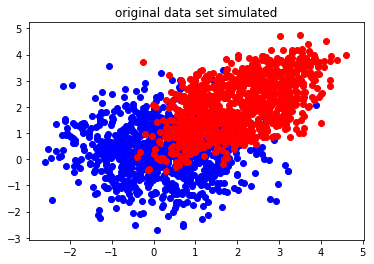

In [14]:
fig, ax = plt.subplots()
ax.scatter(X[0,:], X[1, :], c='blue')
ax.scatter(Y[0,:], Y[1, :], c='red')

plt.title("original data set simulated")
plt.show()

In [15]:
Z_est, Lambda_x, Lambda_y, Psi_x, Psi_y = EM_CCA(X, Y, 2, iters =10, typ='bishop')

In [16]:
X_est, Y_est = reconstruct(Z_est, Lambda_x, Lambda_y, Psi_x, Psi_y)

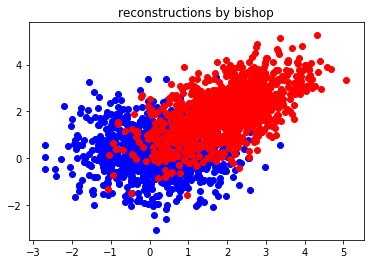

In [17]:
fig, ax = plt.subplots()
ax.scatter(X_est[0,:], X_est[1, :], c='blue')
ax.scatter(Y_est[0,:], Y_est[1, :], c='red')

plt.title("reconstructions by bishop")

plt.show()

In [29]:
Normal = np.random.multivariate_normal

def mean_center(X):
    return X - X.mean(axis=0)

def load_paired_dataset(N):
    P, Q = 4, 3

    amean = np.zeros(P)
    acov  = np.eye(P)
    Xa    = Normal(mean=amean, cov=acov, size=N)

    bmean = np.ones(Q) * 2
    bcov  = np.eye(Q) * 1.5
    bcov[0, 1] = bcov[0, 2] = bcov[1, 2] = 1
    bcov[1, 0] = bcov[2, 0] = bcov[2, 1] = 1
    print(bcov)
    Xb    = Normal(mean=bmean, cov=bcov, size=N)

    Xa = mean_center(Xa)
    Xb = mean_center(Xb)

    assert Xa.shape == (N, P)
    assert Xb.shape == (N, Q)
    return Xa, Xb

[[ 1.5  1.   1. ]
 [ 1.   1.5  1. ]
 [ 1.   1.   1.5]]


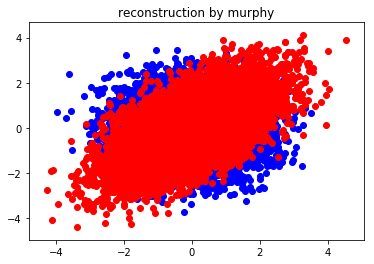

In [34]:
X, Y = load_paired_dataset(10000)
X = X.T
Y = Y.T

Z_est, Lambda_x, Lambda_y, Psi_x, Psi_y = EM_CCA(X, Y, 2, iters =10, typ='murphy')

X_est, Y_est = reconstruct(Z_est, Lambda_x, Lambda_y, Psi_x, Psi_y)

fig, ax = plt.subplots()
ax.scatter(X_est[0,:], X_est[1, :], c='blue')
ax.scatter(Y_est[0,:], Y_est[1, :], c='red')

plt.title("reconstruction by murphy")
plt.show()

(4, 10000)


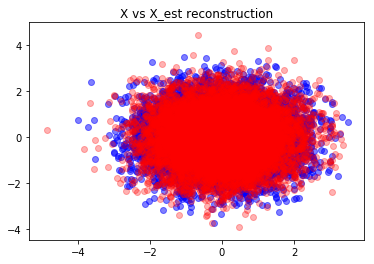

In [37]:
print(X_est.shape)

fig, ax = plt.subplots()
ax.scatter(X_est[0,:], X_est[1, :], c='blue', alpha = 0.5)
ax.scatter(X[0,:], X[1, :], c='red', alpha = 0.3)

plt.title("X vs X_est reconstruction")
plt.show()

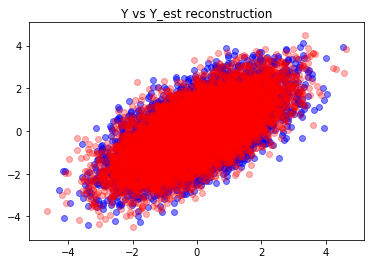

In [36]:
fig, ax = plt.subplots()
ax.scatter(Y_est[0,:], Y_est[1, :], c='blue', alpha = 0.5)
ax.scatter(Y[0,:], Y[1, :], c='red', alpha = 0.3)

plt.title("Y vs Y_est reconstruction")
plt.show()